#**Modelos de decisión lineal y cuadrática**

David Cardenas Peña, PhD.

Edificio de Ingeniería Eléctrica, Oficina 1B-131

email: dcardenasp@utp.edu.co

# Objetivos
* Relacionar las distribuciones de los datos con la clase a la que pertenecen.
* Comprender las etapas de entrenamiento y evaluación de un clasificador.

In [ ]:
#Setup libraries
import scipy.linalg
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs,make_circles
from sklearn.datasets import load_iris

## Funciones auxiliares

Crean las bases de datos y hacen las gráficas

In [ ]:
def blobs():
  #Load database
  X_train, t_train = make_blobs(n_samples=1000, centers=2, random_state=0)
  t_train = t_train*1.0
  N = X_train.shape[0]
  #Data grid to evaluate:
  xmin = X_train.min(0)
  xmax = X_train.max(0)
  x1 = np.linspace(xmin[0], xmax[0], 1000) #Malla de puntos para la variable x1
  x2 = np.linspace(xmin[1], xmax[1], 1000) #Malla de puntos para la variable x2
  X1, X2 = np.meshgrid(x1, x2) #Malla de puntos bi-dimensional
  #Datos para evaluar:
  X_test = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis=1)
  Ntest = X_test.shape[0]

  clases = list(set(t_train)) #Hace un set y luego una lista
  print('Clases:',clases)
  return X_train,t_train,X_test

def three_blobs():
  #Load database
  X_train, t_train = make_blobs(n_samples=1000, centers=3, random_state=2)
  t_train = (t_train==2)*1.0
  N = X_train.shape[0]
  #Data grid to evaluate:
  xmin = X_train.min(0)
  xmax = X_train.max(0)
  x1 = np.linspace(xmin[0], xmax[0], 1000) #Malla de puntos para la variable x1
  x2 = np.linspace(xmin[1], xmax[1], 1000) #Malla de puntos para la variable x2
  X1, X2 = np.meshgrid(x1, x2) #Malla de puntos bi-dimensional
  #Datos para evaluar:
  X_test = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis=1)
  Ntest = X_test.shape[0]

  clases = list(set(t_train)) #Hace un set y luego una lista
  print('Clases:',clases)
  return X_train,t_train,X_test

def circles():
  #Load database
  X_train, t_train  = make_circles(n_samples=1000, factor=.5,  noise=.1)
  N = X_train.shape[0]
  #Data grid to evaluate:
  xmin = X_train.min(0)
  xmax = X_train.max(0)
  x1 = np.linspace(xmin[0], xmax[0], 1000) #Malla de puntos para la variable x1
  x2 = np.linspace(xmin[1], xmax[1], 1000) #Malla de puntos para la variable x2
  X1, X2 = np.meshgrid(x1, x2) #Malla de puntos bi-dimensional
  #Datos para evaluar:
  X_test = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis=1)
  Ntest = X_test.shape[0]

  clases = list(set(t_train)) #Hace un set y luego una lista
  print('Clases:',clases)
  return X_train,t_train,X_test

def plot_boundaries(X_train,t_train,X_test,y_test,boundaries):
  X1 = X_test[:,0].reshape([1000,1000])
  X2 = X_test[:,1].reshape([1000,1000])
  cmap = ['blue','red']
  colors = [cmap[tn] for tn in t_train.astype(int).ravel()]
  plt.figure(figsize=(5,5))
  plt.scatter(X_train[:,0], X_train[:,1], c=colors)#
  cs = plt.contour(X1, X2, y_test.reshape(X1.shape),boundaries)
  plt.clabel(cs, inline=True, fontsize=10)
  plt.show()
  return

def plot_projected_boundaries(X_train,t_train,X_test,t_test,w,mu,boundaries):

  X1 = X_test[:,0].reshape([1000,1000])
  X2 = X_test[:,1].reshape([1000,1000])

  p = np.linspace(0.2,1.1,1000)
  P1, P2 = np.meshgrid(p,p) #Malla de puntos bi-dimensional
  y_plot = sigmoid(w[0] + w[1]*P1 + w[2]*P2)

  cmap = ['blue','red']
  colors = [cmap[tn] for tn in t_train.astype(int).ravel()]

  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.scatter(X_train[:,0], X_train[:,1], c=colors)
  plt.scatter(mu[:,0], mu[:,1], c='red',label='Centroids')
  cs = plt.contour(X1, X2, y_test.reshape(X1.shape),boundaries)
  plt.clabel(cs, inline=True, fontsize=10)
  plt.xlabel('$X_1$')
  plt.ylabel('$X_2$')
  plt.legend()

  plt.subplot(1,2,2)
  plt.scatter(Phi_train[:,1], Phi_train[:,2], c=colors)
  cs = plt.contour(P1, P2, y_plot,boundaries)
  plt.clabel(cs, inline=True, fontsize=10)
  plt.xlabel('$\Phi_1$')
  plt.ylabel('$\Phi_2$')
  plt.show()

# Análisis Discriminante Lineal:

## Actividad 1:

Complete la función `lda_fit` para que entregue el vector de proyección LDA `w` y el umbral de clasificación `c`:

$w=S_w^{-1}(\mathbf{m}_2-\mathbf{m}_1)$

$y_0=w^\top(\frac{N_1\mathbf{m}_1+N_2\mathbf{m}_2}{N})$

$S_w=\Sigma_1+\Sigma_2$

$\mathbf{m}_k=mean(X:t==k)$

$\Sigma_k=cov(X:t==k)$

NOTA: Recuerde cómo se indexan filas en matrices

In [ ]:
def lda_fit(X,t):
  N  = len(t)
  N1 = np.sum(t==1)
  N2 = np.sum(t==0)

  m1 = np.mean(X[t==1, :], axis=0)
  m2 = np.mean(X[t==0, :], axis=0)

  S1 = np.cov(X[t==1, :].T)
  S2 = np.cov(X[t==0, :].T)

  Sw = S1 + S2
  print(Sw.shape, m1.shape)

  w = np.linalg.inv(Sw)@(m2-m1)
  y0 = (1/N)*w.T@(N1*m1 + N2*m2)

  return w,y0

## Actividad 2:

1. Complete la función `lda_decision_function` para que realice la proyección de las muestras $X$ como:

  $a=Xw$


2. Complete la función `lda_predict` para que realice la clasificación de las muestras como:

  $a>=y_0\rightarrow y = 1$

  $a<y_0 \rightarrow y = 0$

NOTA: En la función `lda_predict` use el resultado de `lda_decision_function`

In [ ]:
def lda_decision_function(X,w):

  a = X@w

  return a

def lda_predict(X,w,y0):

  a = lda_decision_function(X,w)

  y = a

  y[y >= y0] = 1
  y[y < y0]  = 0

  return y

## Evaluar el clasificador:

Ahora empleamos sus funciones para clasificar unas bases de datos.

Clases: [0.0, 1.0]
(2, 2) (2,)


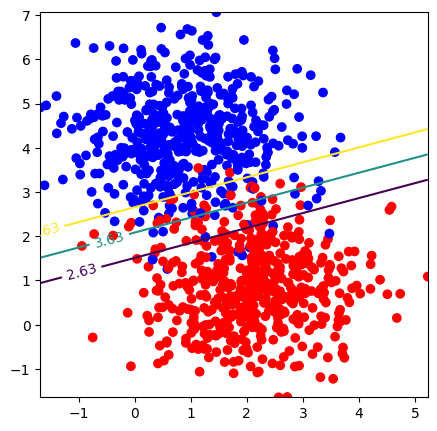

Clases: [0.0, 1.0]
(2, 2) (2,)


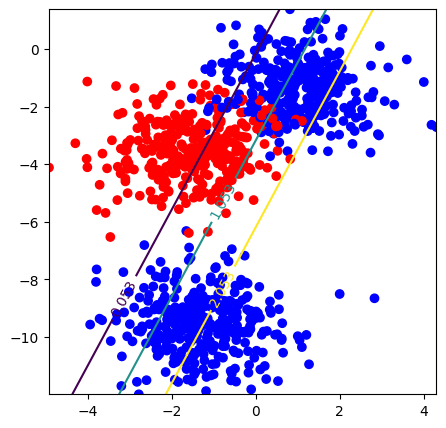

Clases: [0, 1]
(2, 2) (2,)


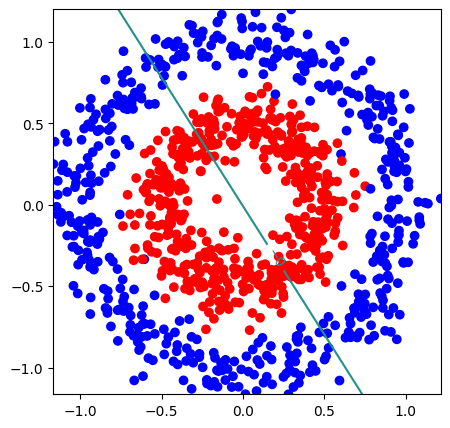

In [ ]:
for dataset in [blobs,three_blobs,circles]:
  #Load database
  X_train,t_train,X_test = dataset()

  #Train classifier
  w,y0 = lda_fit(X_train,t_train)

  #Make predictions
  a_test = lda_decision_function(X_test,w)

  #plot results
  boundaries=[y0-1,y0,y0+1]
  plot_boundaries(X_train,t_train,X_test,a_test,boundaries)

## Actividad 3:
1. Repita la actividad 1 empleando el módulo Linear Discriminant Analysis de scikit-learn (`sklearn.discriminant_analysis.LinearDiscriminantAnalysis`).

2. Guarde en la variable `a_test` el valor de la **función de decisión** del objeto LDA evaluada en los datos `X_test`.

3. Calcule el **acierto** de clasificación en los datos `X_train,t_train` (emplee el método `score` del objeto LDA).


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Clases: [0.0, 1.0]
El acierto de clasificación en los datos de entrenamiento es 0.955


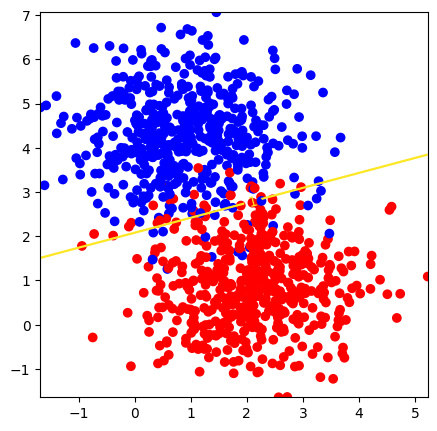

Clases: [0.0, 1.0]
El acierto de clasificación en los datos de entrenamiento es 0.84


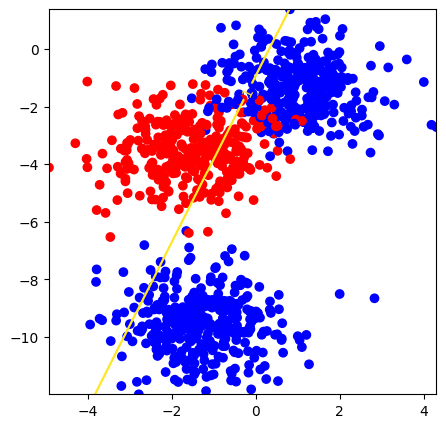

Clases: [0, 1]
El acierto de clasificación en los datos de entrenamiento es 0.49


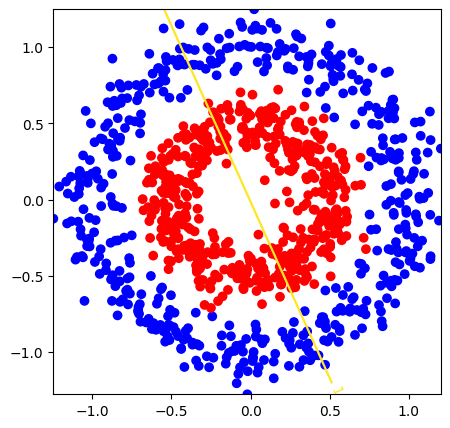

In [ ]:
for dataset in [blobs,three_blobs,circles]:
  #Load database
  X_train,t_train,X_test = dataset()

  #Ponga su código acá:
  clf = LinearDiscriminantAnalysis()
  clf.fit(X_train, t_train)
  a_test = clf.predict(X_test)

  acc_train = clf.score(X_train, t_train)

  print('El acierto de clasificación en los datos de entrenamiento es {}'.format(acc_train))

  #Plot results
  boundaries=[y0-1,y0,y0+1]
  plot_boundaries(X_train,t_train,X_test,a_test,boundaries)

# Análisis Discriminante Cuadrático:


## Actividad 1:
El modelo generativo usa como probabilidad a posteriori de clase una función sigmoide:

$\sigma(a)=\frac{1}{1+exp(-a)}$


Implemente la función sigmoide

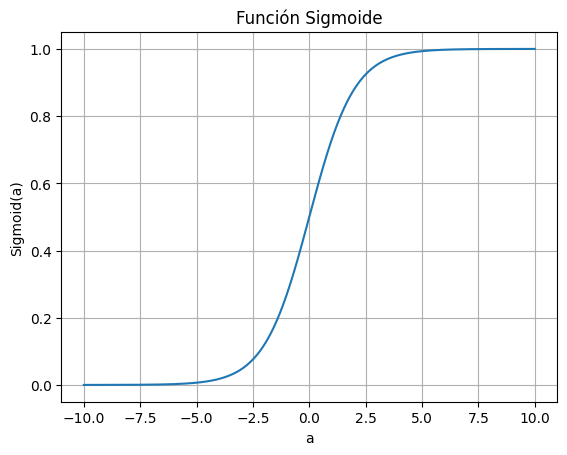

In [4]:


def sigmoid(a):

    return 1 / (1 + np.exp(-a))

a = np.linspace(-10, 10, 1000)
s = sigmoid(a)

# Graficar la función sigmoide
plt.plot(a, s)
plt.title('Función Sigmoide')
plt.xlabel('a')
plt.ylabel('Sigmoid(a)')
plt.grid(True)
plt.show()


## Actividad 2:
Si se asumen distribuciones de clase Gaussianas, la frontera de decisión será cuadrática:

$a=-\frac{1}{2}x^\top Ax+b^\top x + c$

donde

$A=\Sigma_1^{-1}-\Sigma_2^{-1}$

$b=\mu_1\Sigma_1^{-1}-\mu_2\Sigma_2^{-1}$

$c = - \frac{1}{2}(\mu_1^\top\Sigma_1^{-1}\mu_1-\mu_2^\top\Sigma_2^{-1}\mu_2) +log\left\{\left(\frac{|\Sigma_2|}{|\Sigma_1|}\right)^{1/2}\frac{\pi}{1-\pi}\right\}$

Complete la función de decisión.


NOTA: Comparando las ecuaciones acá descritas con las vistas en el curso, se han cambiando algunas transpuestas. Esto se debe a que las muestras se reciben como vector fila y el análisis teórico se realizó con vectores columna.

In [10]:
def quad_decision_function(X,S1,S2,m1,m2,pi):
  #x.shape = (N,D)
  #S1.shape = (D,D)
  #S2.shape = (D,D)
  #m1.shape = (1,D)
  #m2.shape = (1,D)

    A = np.linalg.inv(S1) - np.linalg.inv(S2)
    b = m1.T @ np.linalg.inv(S1) - m2.T @ np.linalg.inv(S2)
    c = -0.5 * (m1.T @ np.linalg.inv(S1) @ m1 - m2.T @ np.linalg.inv(S2) @ m2 + np.log(np.linalg.det(S2) / np.linalg.det(S1)) + np.log(pi[1] / pi[0]))

    # Calcular a para cada ejemplo en X
    a = []
    for x_n in X:
        a_n = -0.5 * x_n.T @ A @ x_n + b.T @ x_n + c
        a.append(a_n)

    return np.array(a).reshape(X.shape[0],1)


## Actividad 3:
La predicción del modelo generativo será entonces
$y = \sigma(a)$

Complete la función de predicción usando sus funciones `quad_decision_function` y `sigmoid`

In [ ]:
def quad_predict(X,S1,S2,m1,m2,pi):
  a = np.zeros((X.shape[0],))
  y = np.zeros_like(a)
  return y


## Actividad 4:
Usando máxima verosimilitud, los parámetros del modelo generativo se pueden calcular como

$\Sigma_1 = cov\{x_n:t_n==1\}$

$\Sigma_2 = cov\{x_n:t_n\neq1\}$

$\mu_1 = mean\{x_n:t_n==1\}$

$\mu_2 = mean\{x_n:t_n\neq1\}$

$\pi=\frac{N_1}{N}$

Complete la función de entrenamiento del modelo generativo

In [ ]:
def quad_fit(X,t):
  #Recuerde que X.shape=(N,D). Use axis=0 en el cálculo de la media y
  # rowvar=False en el cálculo de la covarianza

  m1 = np.zeros((X.shape[1],))
  S1 = np.zeros(X.shape[1])
  pi = 0
  m2 = np.zeros((X.shape[1],))
  S2 = np.zeros(X.shape[1])

  return S1,S2,m1,m2,pi

## Evaluar el clasificador:

Ahora empleamos sus funciones para clasificar unas bases de datos:

Clases: [0.0, 1.0]
Mean 1
[0. 0.]
Covariance 1
[0. 0.]
Mean 2
[0. 0.]
Covariance 2
[0. 0.]
Class 1 prior: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: No contour levels were found within the data range.


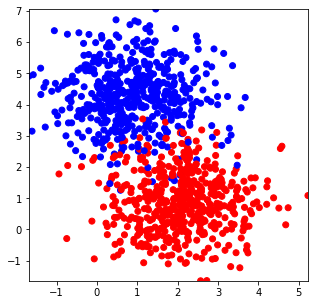

Clases: [0.0, 1.0]
Mean 1
[0. 0.]
Covariance 1
[0. 0.]
Mean 2
[0. 0.]
Covariance 2
[0. 0.]
Class 1 prior: 0


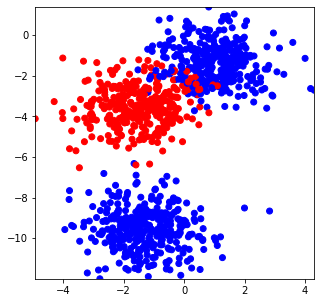

Clases: [0, 1]
Mean 1
[0. 0.]
Covariance 1
[0. 0.]
Mean 2
[0. 0.]
Covariance 2
[0. 0.]
Class 1 prior: 0


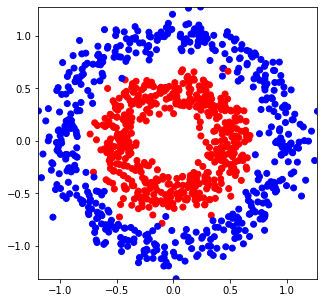

In [ ]:
for dataset in [blobs,three_blobs,circles]:
  #Load database
  X_train,t_train,X_test = dataset()

  #Train classifier
  S1,S2,m1,m2,pi = quad_fit(X_train,t_train)

  #Explore parameters
  print('Mean 1')
  print(m1)
  print('Covariance 1')
  print(S1)
  print('Mean 2')
  print(m2)
  print('Covariance 2')
  print(S1)
  print('Class 1 prior: {}'.format(pi))

  #Make predictions
  y_test = quad_predict(X_test,S1,S2,m1,m2,pi)

  #plot results
  boundaries=np.arange(0.1,1,0.2)
  plot_boundaries(X_train,t_train,X_test,y_test,boundaries)

## Actividad 5:
1. Clasifique las bases de datos empleando el módulo Quadratic Discriminant Analysis de scikit-learn (`sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis`).

2. Guarde en la variable `y_test` el valor de la **probabilidad de predicción** para la clase 1 (columna `0` del resultado del método `predict_proba`) del objeto QDA evaluada en los datos `X_test`.

3. Calcule el **acierto** de clasificación en los datos `X_train,t_train` (emplee el método `score` del objeto QDA).

Clases: [0.0, 1.0]
El acierto de clasificación en los datos de entrenamiento es 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: No contour levels were found within the data range.


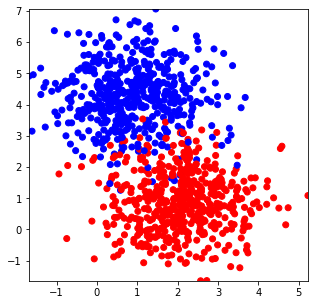

Clases: [0.0, 1.0]
El acierto de clasificación en los datos de entrenamiento es 0


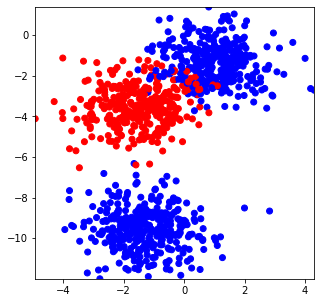

Clases: [0, 1]
El acierto de clasificación en los datos de entrenamiento es 0


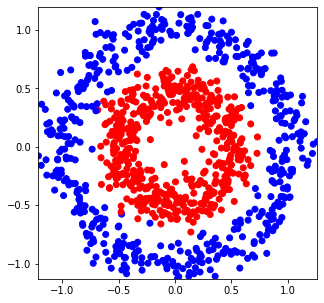

In [ ]:

for dataset in [blobs,three_blobs,circles]:
  #Load database
  X_train,t_train,X_test = dataset()

  #Train classifier


  #Test classifier

  y_test = np.zeros((X_test.shape[0],))

  acc_train = 0

  print('El acierto de clasificación en los datos de entrenamiento es {}'.format(acc_train))

  #plot results
  boundaries=np.arange(0.1,1,0.2)
  plot_boundaries(X_train,t_train,X_test,y_test,boundaries)

#Regresor logístico:

## Actividad 1:
El regresor logístico tiene como función de costo el negativo de la log-verosimilitud:

$E(w)=-t^\top log(y) - (1-t)^\top log(1-y)$

Complete la función de costo:

In [ ]:
def loss(t,y):

  E = 0

  return E

## Actividad 2:
El regresor logístico entrega como predicción el posterior de clase objetivo:

$P(C_1|x)=y(x,w)=\sigma(a)$

donde

$\sigma(a)=\frac{1}{1+exp(-a)}$

y la función de decisión es:

$a=Xw$

Complete la función de predicción.

NOTA: Recuerde que usted ya implementó la función sigmoide $\sigma(a)$ y la función de decisión para un modelo lineal.

In [ ]:
def logistic_predict(X,w):
  a = np.zeros((X.shape[0],))
  y = np.zeros_like(a)
  return y

## Actividad 3:
El regresor logístico se optmiza mediante gradiente descendiente. El gradiente del costo respecto al vector de parámetros es:

$\nabla E(w) = X^\top(y-t)$

Complete la función de gradiente usando sus funciones `logistic_decision_function` y `sigmoid`



In [ ]:
def lr_gradient(w,X,t):
  y = np.zeros((X.shape[0],))
  grad = np.zeros((X.shape[1],))
  return grad

## Actividad 4:
Complete el algoritmo de gradiente descendiente:

1.   Inicializar `w` con valores aleatorios de distribución normal (media cero y varianza unitaria). Se debe cumplir que `w.shape=(D,)` siendo `D` el número de características o columnas en `X`.

2.   Predecir con el modelo actual (use `logistic_predict`) en toda la base de datos.

3.   Calcular el costo.

4.   Calcular el gradiente sólo en un subconjuto de la base de datos (use `lr_gradient`). Consulte el método `np.random.permutation` para generar índices aleatorios.

5.  Actualizar los pesos según la regla del gradente $w(k+1)=w(k)-\eta\nabla E$. La tasa de aprendizaje es un hyperparámetro dado como argumento entrada de la función de entrenamiento.

In [12]:
def logistic_fit(X,t,lr=0.01,maxiter=100):
  #Paso 1: Inicializar w
  w = np.zeros((X.shape[1],))

  L = [] #Lista para almacenar el costo de cada iteración

  for iter in range(maxiter):
   # Paso 2: Realizar predicciones con el modelo actual
        y = logistic_predict(X, w)

        # Paso 3: Calcular el costo
        L.append(-np.mean(t * np.log(y) + (1 - t) * np.log(1 - y)))

        # Paso 4: Calcular el gradiente con un subconjunto aleatorio
        # Generar índices aleatorios
        idx = np.random.permutation(X.shape[0])
        # Seleccionar un subconjunto aleatorio de la base de datos
        X_sub = X[idx[:100], :]
        t_sub = t[idx[:100]]
        # Calcular el gradiente
        grad = lr_gradient(X_sub, t_sub, w)

        # Paso 5: Actualizar los pesos
        w = w - lr * grad

  return w,L

## Actividad 5:

Ahora usamos una base de datos que no es linealmente separable, la proyectamos a un nuevo espacio usando RBFs y usamos un el regresor implementado sobre el espacio proyectado.

*   Cambie el número de iteraciones máximas (`maxiter`) e identifique su efecto.

*   Cambie la tasa de aprendizaje (`lr`) e identifique su efecto.



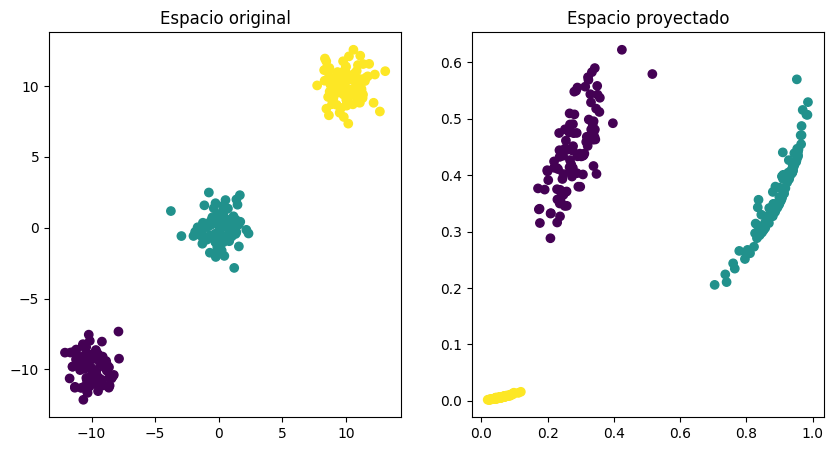

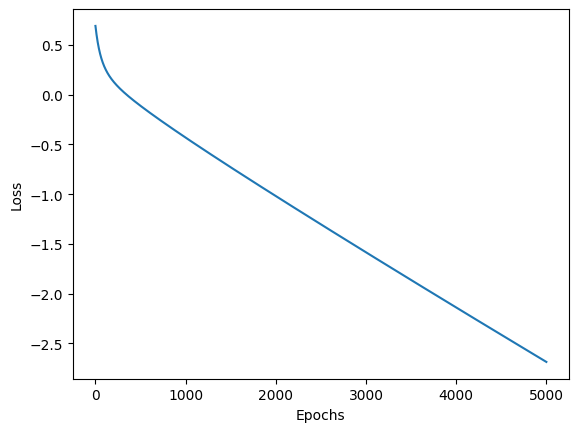

In [14]:
#Basis functions
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import FunctionTransformer

def three_blobs(n_samples=100, centers=[[-10, -10], [0, 0], [10, 10]], cluster_std=[1.0, 1.0, 1.0]):
    X = []
    t = []
    for i, (center, std) in enumerate(zip(centers, cluster_std)):
        X.extend(np.random.normal(center, std, (n_samples, 2)))
        t.extend([i] * n_samples)
    X = np.array(X)
    t = np.array(t)
    return X, t, X

# Función para realizar predicciones con el modelo logístico
def logistic_predict(X, w):
    return 1 / (1 + np.exp(-X @ w))

# Función para calcular el gradiente del costo logístico
def lr_gradient(X, t, w):
    y = logistic_predict(X, w)
    return (X.T @ (y - t)) / X.shape[0]

# Función para entrenar el clasificador logístico
def logistic_fit(X, t, lr=0.01, maxiter=100):
    w = np.zeros(X.shape[1])
    L = []
    for _ in range(maxiter):
        y = logistic_predict(X, w)
        grad = lr_gradient(X, t, w)
        w = w - lr * grad
        L.append(-np.mean(t * np.log(y) + (1 - t) * np.log(1 - y)))
    return w, L

# Función para visualizar los resultados
def plot_projected_boundaries(X_train, t_train, X_test, y_test, w, mu, boundaries):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=t_train, cmap='viridis')
    plt.title('Espacio original')

    plt.subplot(1, 2, 2)
    plt.scatter(Phi_train[:, 1], Phi_train[:, 2], c=t_train, cmap='viridis')
    plt.title('Espacio proyectado')
    plt.show()


mu = np.array([[-1,-3],[-1,-10]])
rbf = lambda X : np.hstack((np.ones((X.shape[0],1)),rbf_kernel(X,mu,gamma=1e-2)))
transformer = FunctionTransformer(rbf)

#Load database
X_train, t_train, X_test = three_blobs()
t_train = t_train

#Transform data
Phi_train = transformer.fit_transform(X_train)
Phi_test = transformer.fit_transform(X_test)

# Train classfier
w,L=logistic_fit(Phi_train,t_train,lr=0.03,maxiter=5000)

# Make predictions
y_test = logistic_predict(Phi_test,w)

#Plot results
boundaries=[0.4,0.5,0.6]

plot_projected_boundaries(X_train,t_train,X_test,y_test,w,mu,boundaries)

plt.plot(L)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Actividad 6:

1. Clasifique la base de datos anterior empleando el regresor logístico de scikit-learn (`sklearn.linear_model.LogisticRegression`).

2. Guarde en la variable `y_test` el valor de la probabilidad de predicción para la clase 1 (columna `0` del resultado del método `predict_proba`) del objeto Regresor Logístico evaluada en los datos `X_test`.

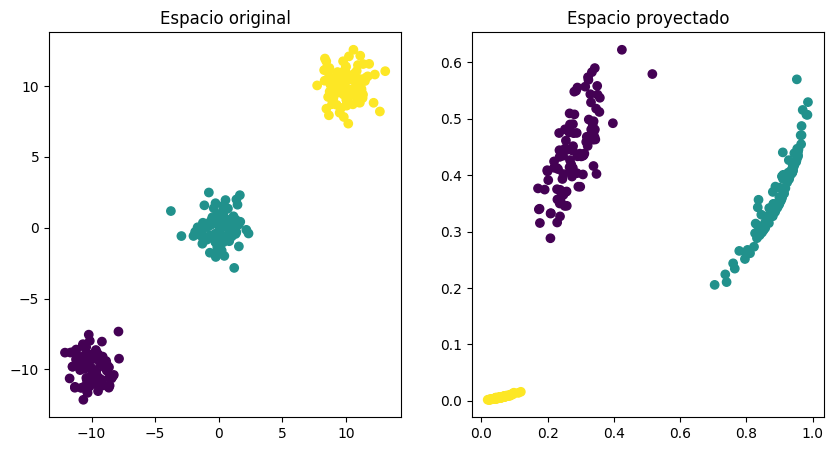

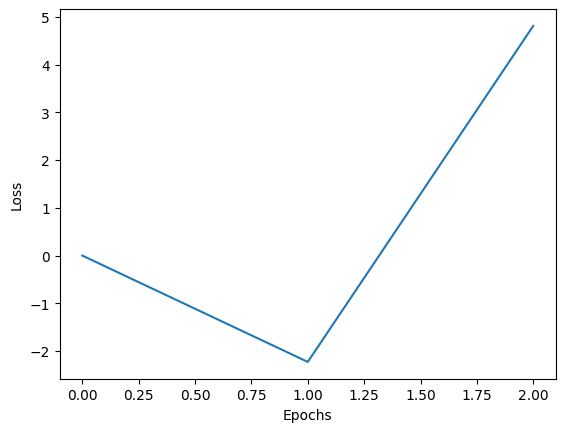

In [17]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=0)
log_reg.fit(X_train, t_train)

Phi_train = transformer.fit_transform(X_train)
Phi_test = transformer.fit_transform(X_test)

# Train classifier
log_reg = LogisticRegression(random_state=0)
log_reg.fit(Phi_train, t_train)

# Make predictions
y_test_proba = log_reg.predict_proba(Phi_test)[:, 0]

# Guardar las probabilidades de la clase 1 en y_test
y_test = y_test_proba

# Plot results
boundaries = np.arange(0.1, 1, 0.2)
plot_projected_boundaries(X_train, t_train, X_test, y_test, log_reg.coef_[0], mu, boundaries)

plt.plot(log_reg.coef_[0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Validación cruzada:

## Actividad 1:
La base de datos mnist contiene imágenes de 28 x 28 con dígitos del cero al nueve. Se puede descargar de https://www.kaggle.com/datasets/oddrationale/mnist-in-csv. Utilizar únicamente el archivo mnist_test.csv.


1. Aplique la validación cruzada a clasificador LDA, QDA y Regresor logístico con los datos de la base de datos `X` y `t`.

2. Determine el porcentaje de clasificación media y su desviación para cada clasificador.



In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


df = pd.read_csv('sample_data/mnist_train_small.csv')

t=df.iloc[:,0]
X=df.iloc[:,1:]

# Normalizar las imágenes
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, random_state=42)

classifiers = {
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'Logistic Regression': LogisticRegression(solver='liblinear', multi_class='auto')
}

# Aplicar validación cruzada y calcular el porcentaje de clasificación media y su desviación
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_train, t_train, cv=5, scoring='accuracy')
    print(f"{name}: {np.mean(scores):.2f} (+/- {np.std(scores):.2f})")


plt.figure(figsize=(10, 6))
plt.bar(classifiers.keys(), [np.mean(scores) for scores in cross_val_score(clf, X_train, t_train, cv=5, scoring='accuracy') for clf in classifiers.values()])
plt.ylabel('Porcentaje de clasificación media')
plt.title('Comparación de clasificadores')
plt.show()

print('La base de datos contiene {} imágenes, cada una con {} pixels'.format(X.shape[0],X.shape[1]))

print('Las clases corresponden a dígitos: {} '.format(np.unique(t)))


LDA: 0.31 (+/- 0.26)


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA: 0.63 (+/- 0.02)
